Here I follow along with d2l.ai and attempt to train an AlexNet on Fashion-MNIST

In [1]:
import torch
import torchvision
from d2l import torch as d2l
from torch import nn

First set up the architecture and test that the dimensionality of the output at each step is correct

In [2]:
class AlexNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            # Input is 1x224x224 because we're using upscaled (yes, yes) Fashion-MNIST
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=(2)),  # out: 96 x 55 x 55
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # out: 96 x 27 x 27
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),  # out: 256 x 27 x 27
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # out: 256 x 13 x 13
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),  # out: 384 x 13 x 13
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256: 384 x 6 x 6
            nn.Flatten(),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=10)  # Fashion-MNIST has 10 classes
        )
        
        self.init_weights()
    
    def init_weights(self):
        for layer in self.net:
            if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
                torch.nn.init.xavier_uniform_(layer.weight)
        
    
    def forward(self, X):
        return self.net(X)

model = AlexNet()

In [3]:
X = torch.randn(size=(1,1,224,224), dtype=torch.float32)

for layer in model.net:
    X = layer(X)
    print(layer.__class__.__name__, " output shape: ", X.shape)

Conv2d  output shape:  torch.Size([1, 96, 55, 55])
ReLU  output shape:  torch.Size([1, 96, 55, 55])
MaxPool2d  output shape:  torch.Size([1, 96, 27, 27])
Conv2d  output shape:  torch.Size([1, 256, 27, 27])
ReLU  output shape:  torch.Size([1, 256, 27, 27])
MaxPool2d  output shape:  torch.Size([1, 256, 13, 13])
Conv2d  output shape:  torch.Size([1, 384, 13, 13])
ReLU  output shape:  torch.Size([1, 384, 13, 13])
Conv2d  output shape:  torch.Size([1, 384, 13, 13])
ReLU  output shape:  torch.Size([1, 384, 13, 13])
Conv2d  output shape:  torch.Size([1, 256, 13, 13])
ReLU  output shape:  torch.Size([1, 256, 13, 13])
MaxPool2d  output shape:  torch.Size([1, 256, 6, 6])
Flatten  output shape:  torch.Size([1, 9216])
Linear  output shape:  torch.Size([1, 4096])
Dropout  output shape:  torch.Size([1, 4096])
ReLU  output shape:  torch.Size([1, 4096])
Linear  output shape:  torch.Size([1, 4096])
Dropout  output shape:  torch.Size([1, 4096])
ReLU  output shape:  torch.Size([1, 4096])
Linear  output s

We read the dataset using torchvision

In [4]:
batch_size = 128

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])

all_set = torchvision.datasets.FashionMNIST("./data", transform=transform, download=True)
test_set = torchvision.datasets.FashionMNIST("./data", transform=transform, download=True, train=False)

# Build a validation set with an 80-20 split
val_idx = int(0.8 * len(all_set))

train_set, val_set = torch.utils.data.random_split(all_set, [val_idx, len(all_set) - val_idx])

all_iter = torch.utils.data.DataLoader(all_set, batch_size=batch_size, shuffle=True)
train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_iter = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

Next we define a function to evaluate accuracy of the model

In [6]:
def evaluate_accuracy_gpu(net, data_iter, device):
    """
    Evaluate the accuracy of the model given by 'net' on 
    the DataLoader given by 'data_iter' using the device 'device'
    """
    net.eval()
    num_correct, num_total = 0, 0
    for i, (X, y) in enumerate(data_iter):
        X, y = X.to(device), y.to(device)
        _, predicted = torch.max(net(X), 1)
        correct = (predicted == y).sum()
        num_correct += correct
        num_total += y.shape[0]
    return float(num_correct) / num_total

And a function to evaluate the cross-entropy loss of the model on a labelled DataLoader

In [7]:
def evaluate_loss(net, data_iter, device):
    net.eval()
    loss = nn.CrossEntropyLoss()
    total_loss = 0
    for i, (X, y) in enumerate(data_iter):
        X, y = X.to(device), y.to(device)
        total_loss += loss(net(X), y)

And finally a function that trains the model and plots results as we go

In [15]:
def train_alexnet(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu()):
    # 1: initialise weights: done when creating the model
    
    # 2: move model to device for training
    net.to(device)
    
    # 3: set up optimizer, loss function, and animation stuff
    loss = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel="epoch number", xlim=[0, num_epochs], legend=["train loss", "train acc", "test acc"])
    
    # 4: training loop
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            net.train()
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            # temporarily disable grad to calculate metrics
            with torch.no_grad():
                train_loss = l
#                 import ipdb; ipdb.set_trace()
                _, preds = torch.max(y_hat, 1)
                train_acc = ((preds == y).sum()) / float(X.shape[0])
            if (i + 1) % 50 == 0:
                animator.add(epoch + (i / len(train_iter)), (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter, device)
        animator.add(epoch + 1, (None, None, test_acc))
    
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')


In [16]:
lr, num_epochs = 0.01, 10

KeyboardInterrupt: 

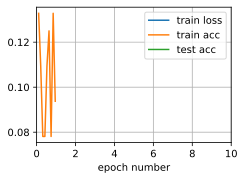

In [17]:
train_alexnet(model, all_iter, test_iter, num_epochs, lr)